# Hepatitis C

# Notebook with EDA and AutoML - [EDA notebook Link](https://www.kaggle.com/amritpal333/hepatitis-c-virus-detection-eda-automl)
Hi, I am Dr. Amrit. In this notebook, we will try to dive deep into this dataset.

Hepatitis C is one of the most commonly spread infections during Blood donation. Its detection is often complex, expensive and time-taking.

So rather than going through traditional pathway, new approaches are trying to detect Hepatitis C status using Blood biomarkers. In certain cases, attempts have been made to even sub-categorize the stage of Hepatitis C.

Hepatitis C is a dangerous disease, with high fatility, hence prevention is the best remedy the keep in mind.


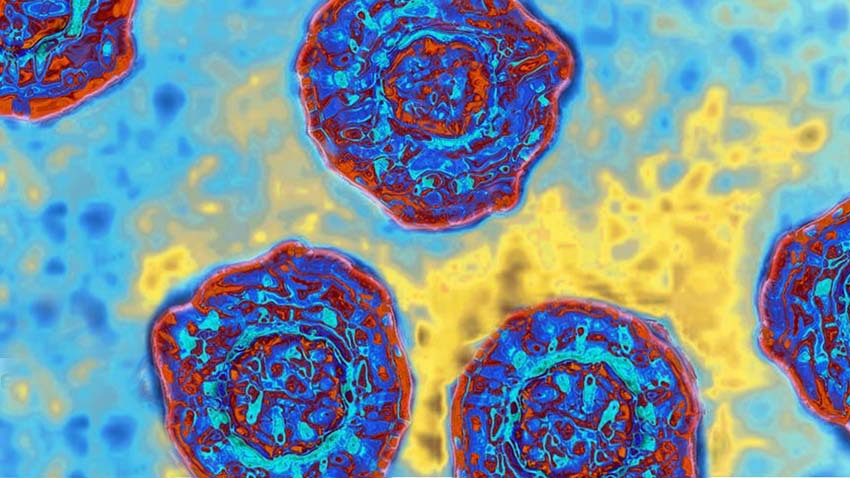

Dataset - https://www.kaggle.com/amritpal333/hepatitis-c-virus-blood-biomarkers



This dataset contains 14 columns, labelled into 4 classes.

## 4 Classes

1. Blood donors
2. Hepatitis C 
   - 'just' Hepatitis C
   - with Fibrosis
   - with Cirrhosis
   
(values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')

# 14 columns 

1. X (Patient ID/No.)
2. Category (diagnosis) 
3. Age (in years)
4. Sex (f,m)
5. ALB
6. ALP
7. ALT
8. AST
9. BIL
10. CHE
11. CHOL
12. CREA
13. GGT
14. PROT

Lets get started by importing things we need

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor , XGBClassifier 
import lightgbm as lgb
from lightgbm import LGBMRegressor , LGBMClassifier
import catboost as cat
from catboost import CatBoostRegressor , CatBoostClassifier

from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('../input/hepatitis-c-virus-blood-biomarkers/hcvdat0.csv')
df.head()

In [ ]:
df["Category"].value_counts()

In [ ]:
df.nunique()

# Exploratory data analysis

In [ ]:
df.describe()

All the values seeem logical.
Age is in logical range.

ALB 	ALP 	ALT 	AST 	BIL 	CHE 	CHOL 	CREA 	GGT 	PROT - Seem in medically possible ranges(healthy or Diseased patient)

In [ ]:
sns.heatmap(df.corr() , annot = True)

Each cell in the correlation matrix is a ‘correlation coefficient‘ between the two variables corresponding to the row and column of the cell.

## A **Correlation coefficient** is a number that denotes the strength of the relationship between two variables.

There are several correlation coefficients, 

1. Pearson’s coefficient(denotted by ρ (rho)) - most common used 
It is defined as the covariance between two variables divided by the product of the standard deviations of the two variables.

## Formula for correlation coefficient between two variables

Where the covariance between X and Y COV(X, Y) is further defined as the ‘expected value of the product of the deviations of X and Y from their respective means’.

- The value of ρ lies between -1 and +1.
- Values nearing +1 indicate the presence of a strong positive relation between X and Y, whereas those nearing -1 indicate a strong negative relation between X and Y.
- Values near to zero mean there is an absence of any relationship between X and Y.


## Our interpretation from Data

### There seems to be some correlations in Biomarker levels. Lets first note them done, and then lets try to make sense out of them.

### More than 0.5 
 - Prot - ALB

### 0.4 - 0.5 
 - ALP - GGT
 - AST - GGT
 

### Less than 0 / Negative values
 - CHOL / ALB / CHE - GGT
 - CHOL /Age / ALB / CHE - CREA
 - BIL / ALB - CHE
 
       

In [ ]:
g = sns.PairGrid(df)
g.map_upper(sns.histplot , log_scale = True)
g.map_lower(sns.kdeplot, fill=True , log_scale = True)
g.map_diag(sns.histplot, kde=True , log_scale = True)

# Train simple XGBoost

In [ ]:
df = pd.read_csv('../input/hepatitis-c-virus-blood-biomarkers/hcvdat0.csv')
df

In [ ]:
#df.info()

df['Sex'].loc[df['Sex'] == 'm'] = 1

df['Sex'].loc[df['Sex'] == 'f'] = 0
df['Sex']

In [ ]:
df['Sex'] = df['Sex'].astype('int')

In [ ]:
df = df.drop(columns = ['Unnamed: 0'])

In [ ]:

df_train  , df_eval = train_test_split(df , test_size = 0.2 , shuffle = True)

targets = ['Category']

y_train = df_train[targets]
x_train = df_train.drop(columns = targets) 

y_test = df_eval[targets]
x_test = df_eval.drop(columns = targets) 

x_train

In [ ]:
model_xgboost = XGBClassifier( colsample_bytree=0.7, learning_rate = 0.03 ,
                                  n_estimators=100, subsample=0.7,alpha=0.9) # define
    
model_xgboost.fit(x_train,  y_train) #fit
preds = model_xgboost.predict(x_test) #predict 

In [ ]:
preds

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(preds , y_test))
sns.set(rc={"figure.figsize":(10, 7)})
sns.heatmap(pd.DataFrame(confusion_matrix(preds , y_test)) , cmap="magma" , annot = True)


As we can see, model isnt really doing good. Its mostly predicting everything as Class0. Lets try to improve on this.

# Randomized Search in XGBoost

In [ ]:
#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
from sklearn.model_selection import RandomizedSearchCV


params = {
    'learning_rate' : [0.01 , 0.05 , 0.1 ,0.2],
    'max_depth'  : [3 ,4 , 15],
    'min_child_weight' : [1,3,5,7],
    'gamma' : [0.0 , 0.1 , 0.2 , 0.3],
    'colsample_bytree' : [0.3 , 0.4 , 0.5],
    'n_estimators' : [750, 1000]}

model_xgboost = XGBClassifier() 

random_search = RandomizedSearchCV(model_xgboost , param_distributions = params , 
                                   n_iter = 3 , cv = 3 , scoring = 'accuracy', n_jobs=-1 , verbose= 3 )

random_search.fit(x_train, y_train)

print(random_search.best_estimator_)
print(random_search.best_params_)


model_xgboost11 = random_search.best_estimator_

model_xgboost11.fit(x_train, y_train) #fit

preds = model_xgboost11.predict(x_test) #predict 

print(classification_report(preds , y_test))
sns.set(rc={"figure.figsize":(10, 7)})
sns.heatmap(pd.DataFrame(confusion_matrix(preds , y_test)) , cmap="magma" , annot = True)


In [ ]:
model_xgboost = XGBClassifier() 

random_search = RandomizedSearchCV(model_xgboost , param_distributions = params , 
                                   n_iter = 1 , cv = 3 , scoring = 'f1_macro' , n_jobs=-1 , verbose= 3 )

random_search.fit(x_train, y_train)

print(random_search.best_estimator_)
print(random_search.best_params_)


model_xgboost11 = random_search.best_estimator_

model_xgboost11.fit(x_train, y_train) #fit

preds = model_xgboost11.predict(x_test) #predict 

print(classification_report(preds , y_test))
sns.set(rc={"figure.figsize":(10, 7)})
sns.heatmap(pd.DataFrame(confusion_matrix(preds , y_test)) , cmap="magma" , annot = True)
